In [ ]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split , cross_val_score , RandomizedSearchCV , GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.utils import resample
from matplotlib import cm

In [ ]:
#Dataset
mnist = fetch_openml('mnist_784', version=1)


x = mnist.data
y = mnist.target

#Splitting data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set dimensions: {x_train.shape}, {y_train.shape}")
print(f"Test set dimensions: {x_test.shape}, {y_test.shape}")

Training set dimensions: (56000, 784), (56000,)
Test set dimensions: (14000, 784), (14000,)


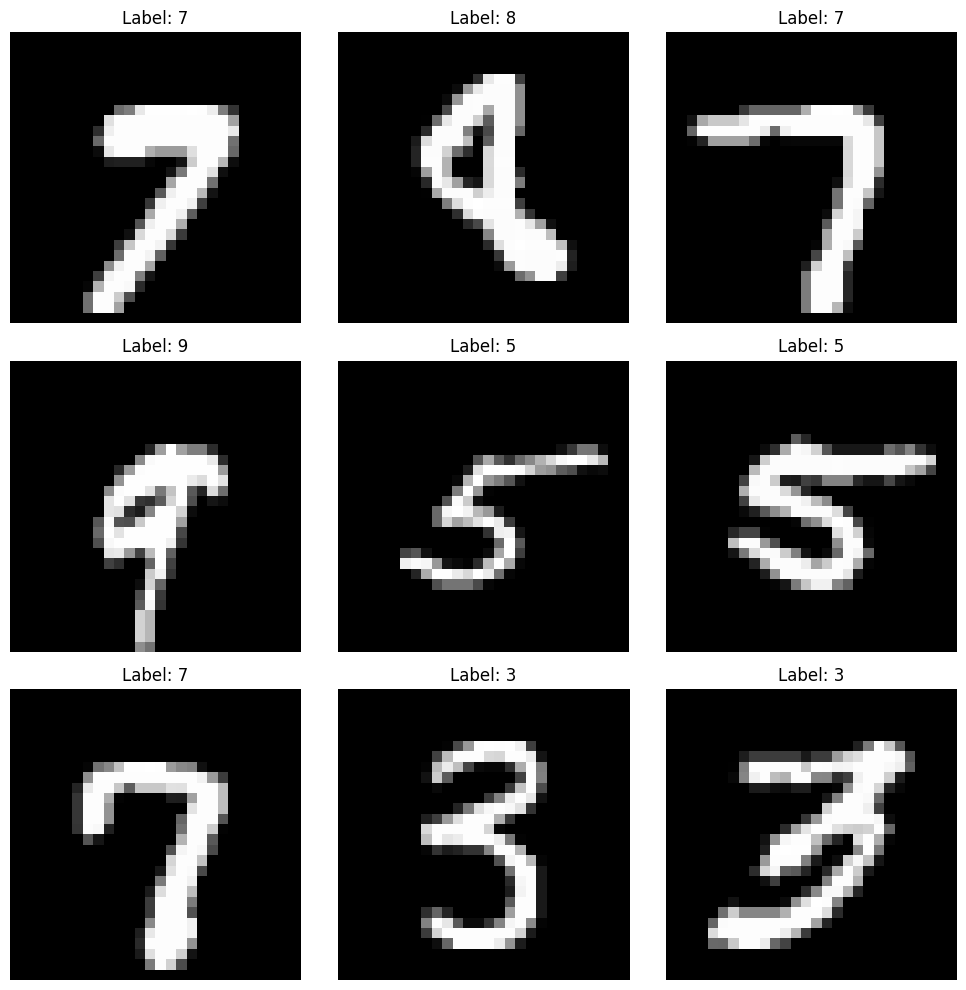

x_train dimensions: (56000, 784)
x_test dimensions: (14000, 784)
Label types: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [ ]:
#Visualizing random images from the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    index = np.random.randint(0, x_train.shape[0])
    image = x_train.iloc[index].values.reshape(28, 28)
    label = y_train.iloc[index]


    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#Printing dataset dimensions and unique labels
print(f"x_train dimensions: {x_train.shape}")
print(f"x_test dimensions: {x_test.shape}")
print(f"Label types: {np.unique(y_train)}")

In [ ]:
svm_model = SVC()

#Creating a subset of the training data for faster hyperparameter tuning
x_train_subset, y_train_subset = resample(x_train, y_train, n_samples=2500, random_state=42)
print(f"Subset dimensions: {x_train_subset.shape}, {y_train_subset.shape}")

Subset dimensions: (2500, 784), (2500,)


In [ ]:
#Running five-fold cross-valuation to assess the model's baseline correctness
cv_scores = cross_val_score(svm_model, x_train_subset, y_train_subset, cv=5, scoring='accuracy')

print(f"Cross-Validation accuracy scores: {cv_scores}")
print(f"Minimum accuracy score: {cv_scores.min()}")
print(f"Maximum accuracy score: {cv_scores.max()}")
print(f"Mean accuracy score: {cv_scores.mean()}")


Cross-Validation accuracy scores: [0.948 0.942 0.948 0.928 0.92 ]
Minimum accuracy score: 0.92
Maximum accuracy score: 0.948
Mean accuracy score: 0.9372


In [ ]:
#Hyperparameter
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']}



#RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1)


random_search.fit(x_train_subset, y_train_subset)

print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best accuracy score: {random_search.best_score_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best accuracy score: 0.942795343557087


In [ ]:
param_grid = {
    'C': [1, 10],
    'gamma': ['scale'],
    'kernel': ['rbf'] }


#GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1 )


grid_search.fit(x_train_subset, y_train_subset)

print(f"Best hyperparameters with GridSearchCV: {grid_search.best_params_}")
print(f"Best accuracy score with GridSearchCV: {grid_search.best_score_}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best hyperparameters with GridSearchCV: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy score with GridSearchCV: 0.942795343557087


<ipython-input-18-9c054d953c23>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_colormap = cm.get_cmap('pink', 256)


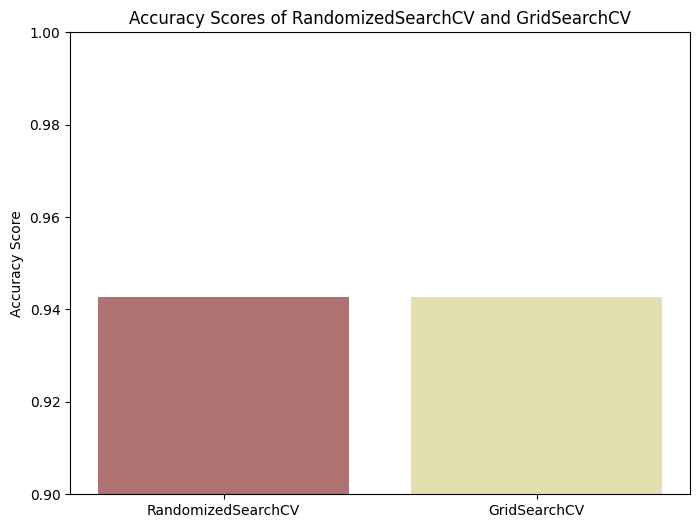

In [ ]:
#Evaluating RandomizedSearchCV and GridSearchCV
methods = ['RandomizedSearchCV', 'GridSearchCV']
scores = [random_search.best_score_, grid_search.best_score_]


pink_colormap = cm.get_cmap('pink', 256)
colors = [pink_colormap(0.3), pink_colormap(0.7)]
plt.figure(figsize=(8, 6))
plt.bar(methods, scores, color=colors)
plt.title('Accuracy Scores of RandomizedSearchCV and GridSearchCV')
plt.ylabel('Accuracy Score')
plt.ylim(0.9, 1.0)
plt.show()

The same set of hyperparameters was chosen by both methods. RandomizedSearchCV can quickly find the right hyperparameters in a large search space, as shown here. Each number is the same because GridSearchCV was used to check the RandomizedSearchCV data in a smaller area.

It is faster for RandomizedSearchCV to run on a random group than to try all possible combinations of hyperparameters. GridSearchCV may take longer because it looks for hyperparameters more thoroughly, but the results are more likely to be correct.


Accuracy score on the test set: 0.9450714285714286


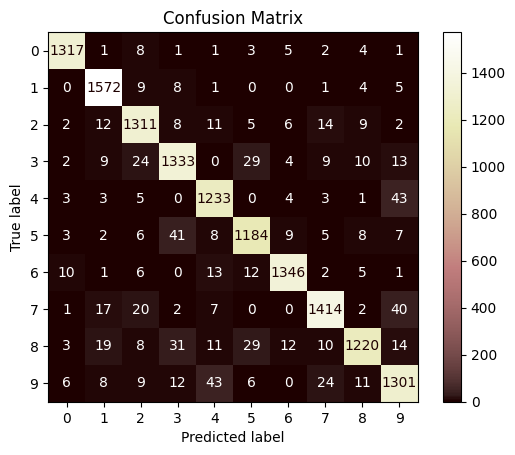

In [ ]:
#Evaluating the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test)

#Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy score on the test set: {test_accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='pink')
plt.title('Confusion Matrix')
plt.show()


The accuracy rate on the test set is really impressive, indicating that the model can generalize well.
A result that matches the cross-validation accuracy rate was achieved. This shows that the model isn't overfitting.

The accuracy rate from cross-validation might be a bit lower since it checks how well the model performs on various data subsets and considers possible variations. The results from the test set are more consistent and demonstrate the final performance.

Both RandomizedSearchCV and GridSearchCV improved the performance on the test set. Using the default SVM hyperparameters wouldn't have allowed for such a high accuracy rate to be achieved.

The confusion matrix shows how well the model is performing and where it makes mistakes. Even though the classifications usually work well, there are mistakes noted between similar figures like Label 3 and Label 5. The visual similarity of the figures may be the cause of these errors.